In [ ]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
training_data = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose ([ 
        transforms.ToTensor () 
        ])
)

test_data = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.Compose ([ 
        transforms.ToTensor () 
        ])
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
batch_size = 100

In [ ]:
batch_size_test = 100

In [ ]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size= batch_size, shuffle=True, num_workers=2) 

In [ ]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size= batch_size_test, shuffle=False, num_workers=2) 

In [ ]:
 from torch.nn.utils import weight_norm

In [ ]:
discriminator = nn.Sequential(
    #  1 x 28 x 28
    (nn.Linear(784, 1024)),
    nn.Dropout(p=0.3),
    nn.LeakyReLU(0.2, inplace=True),
    (nn.Linear(1024, 512)),
    nn.Dropout(p=0.3),
    nn.LeakyReLU(0.2, inplace=True),
    (nn.Linear(512, 128)),
    nn.Dropout(p=0.3),
    nn.LeakyReLU(0.2, inplace=True),
    (nn.Linear(128, 1)),
    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
latent_size = 100
generator = nn.Sequential(       
        weight_norm(nn.Linear(latent_size, 128)),
        nn.LeakyReLU(0.2, inplace=True),
        (nn.Linear(128, 256)),
        nn.LeakyReLU(0.2, inplace=True),
        weight_norm(nn.Linear(256, 512)),
        nn.LeakyReLU(0.2, inplace=True),
        (nn.Linear(512, 784)),
        nn.BatchNorm1d(784),
        nn.Sigmoid()
)

In [ ]:
latent_size = 100

In [ ]:
opt1 = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

In [ ]:
opt2 = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [ ]:
BCE_loss1 = torch.nn.MSELoss()
BCE_loss2 = torch.nn.MSELoss()

In [ ]:
device = torch.device("cuda")

In [ ]:
discriminator.to(device)
generator.to(device)

Sequential(
  (0): Linear(in_features=100, out_features=128, bias=True)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Linear(in_features=128, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2, inplace=True)
  (4): Linear(in_features=256, out_features=512, bias=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Linear(in_features=512, out_features=784, bias=True)
  (7): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Sigmoid()
)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
from torch.autograd import Variable


In [ ]:
losses_generator = []
losses_discriminator = []
real_score = []
fake_score = []
real_scores = []
fake_scores = []
epochs = 700
losses_g = []
losses_d = []
for epoch in range(epochs):
  loss_d_per_epoch = []
  loss_g_per_epoch = []
  real_score_per_epoch = []
  fake_score_per_epoch = []
  for real_images, _ in tqdm(train_loader):
    opt1.zero_grad()
    real_images = real_images.to(device)
    real_images = real_images.view(-1, 784)
    real_preds = discriminator(real_images)
    #присвоим реальному изображению метку класса 1
    real_targets = torch.ones(real_images.size(0), 1, device=device) #- torch.full((real_images.size(0), 1), np.random.uniform(0,0.05), device=device)  
    #учим дисриминатор предсказывать эту метку класса
    real_loss = BCE_loss1(real_preds, real_targets)
    #берем латентный вектор
    latent = torch.randn(batch_size, latent_size, device=device)
    #генерируем изображение
    fake_images = generator(latent)
    #присваимваем метку класса 0
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device) #+ torch.full((real_images.size(0), 1), np.random.uniform(0,0.05), device=device)
    #подвем в дискриминатор, считаем лосс
    fake_preds = discriminator(fake_images)
    fake_loss = BCE_loss2(fake_preds, fake_targets)
    #считаем скор и делаем шаг
    real_score_per_epoch.append(torch.mean(real_preds).item())
    fake_score_per_epoch.append(torch.mean(fake_preds).item())
    loss_d = real_loss + fake_loss
    loss_d.backward()
    opt1.step()
    loss_d_per_epoch.append(loss_d.item())
    #обучим генератор
    opt2.zero_grad()
        
      #генерируем изображение
    latent = torch.randn(batch_size, latent_size, device=device)
    fake_images = generator(latent)
        
    #подаем изображение дискриминатору 
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    #считаем лосс генератора 
    loss_g = BCE_loss2(preds, targets)
    # делаем шаг
    loss_g.backward()
    opt2.step()
    loss_g_per_epoch.append(loss_g.item())
  if (epoch % 5 == 0):  
    torch.save(generator, "model_gen" + str(epoch) + ".zip")
    torch.save(discriminator, "model_dis" + str(epoch) + ".zip")
  print(f'loss generator on {epoch} = {np.mean(loss_g_per_epoch)}')
  print(f'loss discriminator on {epoch} = {np.mean(loss_d_per_epoch)}')
  print(f'real scores on {epoch} = {np.mean(real_score_per_epoch)}')
  print(f'fake scores on {epoch} = {np.mean(fake_score_per_epoch)}')
  losses_g.append(np.mean(loss_g_per_epoch))
  losses_d.append(np.mean(loss_d_per_epoch))
  real_scores.append(np.mean(real_score_per_epoch))
  fake_scores.append(np.mean(fake_score_per_epoch))

  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 600 = 0.5827876069148381
loss discriminator on 600 = 0.30361469847460587
real scores on 600 = 0.6757400955756505
fake scores on 600 = 0.2747678421189388


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 601 = 0.5843588109811148
loss discriminator on 601 = 0.30491563220818835
real scores on 601 = 0.6744311873118083
fake scores on 601 = 0.27399307498087483


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 602 = 0.5803534064193566
loss discriminator on 602 = 0.3010053004324436
real scores on 602 = 0.6758708034952482
fake scores on 602 = 0.27222360476851465


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 603 = 0.580224340458711
loss discriminator on 603 = 0.3036871834844351
real scores on 603 = 0.6749204231301943
fake scores on 603 = 0.27338218197226527


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 604 = 0.5818959275881449
loss discriminator on 604 = 0.30280881889164446
real scores on 604 = 0.6751004622379939
fake scores on 604 = 0.273349849867324


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 605 = 0.583022167980671
loss discriminator on 605 = 0.3030940386156241
real scores on 605 = 0.6757995801170668
fake scores on 605 = 0.27420926904926696


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 606 = 0.5840402749677499
loss discriminator on 606 = 0.30472005618115267
real scores on 606 = 0.6742392075061798
fake scores on 606 = 0.27501020938158033


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 607 = 0.5837359723945459
loss discriminator on 607 = 0.3050435516983271
real scores on 607 = 0.6743279191851616
fake scores on 607 = 0.2746164045482874


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 608 = 0.5817292266090711
loss discriminator on 608 = 0.30332528000076614
real scores on 608 = 0.6747144061326981
fake scores on 608 = 0.27389334539572396


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 609 = 0.5819788380463918
loss discriminator on 609 = 0.30627482319871585
real scores on 609 = 0.6739475900928179
fake scores on 609 = 0.27604253207643825


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 610 = 0.5799438698589802
loss discriminator on 610 = 0.3036715930203597
real scores on 610 = 0.6754301144679388
fake scores on 610 = 0.27437990173697474


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 611 = 0.5793532188733419
loss discriminator on 611 = 0.30524481408298015
real scores on 611 = 0.6742506915330887
fake scores on 611 = 0.27595165306081376


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 612 = 0.5849653798838457
loss discriminator on 612 = 0.3041916502763828
real scores on 612 = 0.6751905462145805
fake scores on 612 = 0.27393322488913935


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 613 = 0.5841820590694745
loss discriminator on 613 = 0.30575395631293456
real scores on 613 = 0.6750698014100392
fake scores on 613 = 0.2763970860342185


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 614 = 0.5834627789755662
loss discriminator on 614 = 0.30271162239213784
real scores on 614 = 0.674937604367733
fake scores on 614 = 0.27324764369676513


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 615 = 0.5837339267631372
loss discriminator on 615 = 0.3032961284617583
real scores on 615 = 0.6750233953197797
fake scores on 615 = 0.27342847066620984


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 616 = 0.5792313028872013
loss discriminator on 616 = 0.30415398985147474
real scores on 616 = 0.6748072544733683
fake scores on 616 = 0.27396698200454317


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 617 = 0.5877623807390531
loss discriminator on 617 = 0.30505592371026674
real scores on 617 = 0.6744965229431789
fake scores on 617 = 0.2756352791314324


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 618 = 0.581230792949597
loss discriminator on 618 = 0.3024977080275615
real scores on 618 = 0.6751592657963434
fake scores on 618 = 0.2734467910726865


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 619 = 0.584453461766243
loss discriminator on 619 = 0.3030808291832606
real scores on 619 = 0.6745680750409762
fake scores on 619 = 0.2731005315234264


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 620 = 0.5840092981358369
loss discriminator on 620 = 0.3056587531914314
real scores on 620 = 0.6747752484679223
fake scores on 620 = 0.2762058880055944


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 621 = 0.5803808212776979
loss discriminator on 621 = 0.30199041331807774
real scores on 621 = 0.6749276546637217
fake scores on 621 = 0.27121395111083985


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 622 = 0.5822280539075534
loss discriminator on 622 = 0.3059979175279538
real scores on 622 = 0.6745063716173172
fake scores on 622 = 0.2766507215797901


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 623 = 0.5814563112457594
loss discriminator on 623 = 0.30725379633406796
real scores on 623 = 0.6730995736519496
fake scores on 623 = 0.2763514798382918


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 624 = 0.5838874558607737
loss discriminator on 624 = 0.30371988599499067
real scores on 624 = 0.6750455576181412
fake scores on 624 = 0.27282350427781543


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 625 = 0.5830875697235266
loss discriminator on 625 = 0.30676551510890326
real scores on 625 = 0.6739855566620827
fake scores on 625 = 0.27683904183407626


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 626 = 0.5840123297770818
loss discriminator on 626 = 0.3021853298693895
real scores on 626 = 0.675167860686779
fake scores on 626 = 0.2719473847746849


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 627 = 0.5807409574091434
loss discriminator on 627 = 0.3066778956602017
real scores on 627 = 0.6728076459964116
fake scores on 627 = 0.2758328415080905


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 628 = 0.5812429468830427
loss discriminator on 628 = 0.3050082028657198
real scores on 628 = 0.6744290997584661
fake scores on 628 = 0.2746160423507293


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 629 = 0.5817261364559333
loss discriminator on 629 = 0.30417679965496064
real scores on 629 = 0.675022799273332
fake scores on 629 = 0.27404352008054655


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 630 = 0.5840158741672834
loss discriminator on 630 = 0.30327028843263787
real scores on 630 = 0.6747659415006637
fake scores on 630 = 0.2729881379567087


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 631 = 0.5824389162659646
loss discriminator on 631 = 0.3024300580720107
real scores on 631 = 0.6743531061212221
fake scores on 631 = 0.2707869455963373


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 632 = 0.5823111979663372
loss discriminator on 632 = 0.3044889518370231
real scores on 632 = 0.6750946820775667
fake scores on 632 = 0.2754231194530924


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 633 = 0.5839277852078278
loss discriminator on 633 = 0.3036801456908385
real scores on 633 = 0.675614194671313
fake scores on 633 = 0.2745581430196762


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 634 = 0.5822706479827563
loss discriminator on 634 = 0.305034152045846
real scores on 634 = 0.6740949325760206
fake scores on 634 = 0.27497789975255726


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 635 = 0.584205495963494
loss discriminator on 635 = 0.30244300156831744
real scores on 635 = 0.6750813952088356
fake scores on 635 = 0.27207988214989504


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 636 = 0.5825132110218207
loss discriminator on 636 = 0.3037522391974926
real scores on 636 = 0.6759397462010384
fake scores on 636 = 0.27473747537471355


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 637 = 0.5805436236659686
loss discriminator on 637 = 0.3039591704805692
real scores on 637 = 0.674509873787562
fake scores on 637 = 0.2731800582880775


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 638 = 0.5801892546315988
loss discriminator on 638 = 0.30203047921260195
real scores on 638 = 0.6749587320288022
fake scores on 638 = 0.2721139013146361


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 639 = 0.582122147232294
loss discriminator on 639 = 0.30238712958991526
real scores on 639 = 0.6749078437685967
fake scores on 639 = 0.2725989683593313


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 640 = 0.5824244948724906
loss discriminator on 640 = 0.30481844472388425
real scores on 640 = 0.6753061772386233
fake scores on 640 = 0.27579396198193235


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 641 = 0.5816104538738728
loss discriminator on 641 = 0.3064612975716591
real scores on 641 = 0.6736918208996455
fake scores on 641 = 0.2765575722853343


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 642 = 0.5824111646910508
loss discriminator on 642 = 0.3023999806245168
real scores on 642 = 0.6751867373784383
fake scores on 642 = 0.2721269623562694


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 643 = 0.5821906714638074
loss discriminator on 643 = 0.306526121844848
real scores on 643 = 0.6749239654342334
fake scores on 643 = 0.27803007253756123


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 644 = 0.5830339946349462
loss discriminator on 644 = 0.3061211742957433
real scores on 644 = 0.6740990155935287
fake scores on 644 = 0.2756014941415439


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 645 = 0.5852164129416147
loss discriminator on 645 = 0.30329168411592644
real scores on 645 = 0.6760654387871424
fake scores on 645 = 0.2742651551030576


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 646 = 0.5825566631555558
loss discriminator on 646 = 0.3042037377754847
real scores on 646 = 0.6763095274567604
fake scores on 646 = 0.2755769117673238


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 647 = 0.5866756495336691
loss discriminator on 647 = 0.30300258825222653
real scores on 647 = 0.6741264414787292
fake scores on 647 = 0.2720235577598214


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 648 = 0.5806031795839469
loss discriminator on 648 = 0.3058881541341543
real scores on 648 = 0.6742765030264855
fake scores on 648 = 0.276679675343136


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 649 = 0.584712851246198
loss discriminator on 649 = 0.3040557853132486
real scores on 649 = 0.6748920738697052
fake scores on 649 = 0.27396295181165137


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 650 = 0.5843493031958739
loss discriminator on 650 = 0.3019234279791514
real scores on 650 = 0.6750525720914204
fake scores on 650 = 0.2716953817754984


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 651 = 0.5802560137212276
loss discriminator on 651 = 0.304270106703043
real scores on 651 = 0.6742481782039007
fake scores on 651 = 0.27374333776533605


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 652 = 0.5810730864604314
loss discriminator on 652 = 0.3044781895975272
real scores on 652 = 0.6760731715957323
fake scores on 652 = 0.27626533914357426


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 653 = 0.5822813561558724
loss discriminator on 653 = 0.3042577972263098
real scores on 653 = 0.6754675142963728
fake scores on 653 = 0.2757155035684506


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 654 = 0.5825721554458141
loss discriminator on 654 = 0.30348169575134915
real scores on 654 = 0.6747741895914078
fake scores on 654 = 0.2733992193887631


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 655 = 0.5815509284039339
loss discriminator on 655 = 0.30435802233715853
real scores on 655 = 0.6743211568395296
fake scores on 655 = 0.2742514077325662


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 656 = 0.5813650227089723
loss discriminator on 656 = 0.3042847978572051
real scores on 656 = 0.6744966344038645
fake scores on 656 = 0.27330613680183885


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 657 = 0.5807878480354944
loss discriminator on 657 = 0.3024614869306485
real scores on 657 = 0.6755947724978129
fake scores on 657 = 0.27269971487422784


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 658 = 0.5829589919249216
loss discriminator on 658 = 0.30518679914375146
real scores on 658 = 0.6744403864940007
fake scores on 658 = 0.2745954060678681


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 659 = 0.5847729270160198
loss discriminator on 659 = 0.303688001781702
real scores on 659 = 0.6755663813153903
fake scores on 659 = 0.27487646802018084


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 660 = 0.5815609672665596
loss discriminator on 660 = 0.30315266000727814
real scores on 660 = 0.6743774394194285
fake scores on 660 = 0.2732568855583668


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 661 = 0.5807182943324248
loss discriminator on 661 = 0.3046489371359348
real scores on 661 = 0.6741804545124371
fake scores on 661 = 0.2741825474301974


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 662 = 0.5828646231194338
loss discriminator on 662 = 0.3064022309333086
real scores on 662 = 0.6746328183015188
fake scores on 662 = 0.2763417678574721


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 663 = 0.5828810780247052
loss discriminator on 663 = 0.3039206303159396
real scores on 663 = 0.6748847968379657
fake scores on 663 = 0.2746463149723907


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 664 = 0.5821728621919949
loss discriminator on 664 = 0.306116814215978
real scores on 664 = 0.6752268756429355
fake scores on 664 = 0.27822763012101254


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 665 = 0.5811747726301352
loss discriminator on 665 = 0.30183951963980993
real scores on 665 = 0.6760836964845658
fake scores on 665 = 0.2720945385967692


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 666 = 0.5827187789976597
loss discriminator on 666 = 0.3050897484272718
real scores on 666 = 0.6744404525558154
fake scores on 666 = 0.2754236955444018


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 667 = 0.5819357193509738
loss discriminator on 667 = 0.30287677014867465
real scores on 667 = 0.6747556340694427
fake scores on 667 = 0.2735307288914919


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 668 = 0.5818066101769607
loss discriminator on 668 = 0.3046705773472786
real scores on 668 = 0.6759061919649442
fake scores on 668 = 0.2760962745298942


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 669 = 0.5823787652949493
loss discriminator on 669 = 0.3043513541420301
real scores on 669 = 0.6751244963208834
fake scores on 669 = 0.2746083348616958


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 670 = 0.5831663981080055
loss discriminator on 670 = 0.30313091836869716
real scores on 670 = 0.6747369160254796
fake scores on 670 = 0.27286355377485355


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 671 = 0.5818473482131958
loss discriminator on 671 = 0.3056956440210342
real scores on 671 = 0.673447593152523
fake scores on 671 = 0.27460399207969505


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 672 = 0.5822582387427488
loss discriminator on 672 = 0.3034659727414449
real scores on 672 = 0.6752800902724266
fake scores on 672 = 0.2735938898722331


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 673 = 0.5828830171128114
loss discriminator on 673 = 0.3028054961313804
real scores on 673 = 0.6749819926420848
fake scores on 673 = 0.27277189812933406


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 674 = 0.581051897952954
loss discriminator on 674 = 0.3036954879015684
real scores on 674 = 0.6755428366859754
fake scores on 674 = 0.2746247658630212


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 675 = 0.582115223457416
loss discriminator on 675 = 0.30470961317420003
real scores on 675 = 0.6745252919197082
fake scores on 675 = 0.2757533707221349


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 676 = 0.581374699473381
loss discriminator on 676 = 0.3034903310984373
real scores on 676 = 0.6757959559559822
fake scores on 676 = 0.27379383716732264


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 677 = 0.5794235612948736
loss discriminator on 677 = 0.3038515468935172
real scores on 677 = 0.6758807097872098
fake scores on 677 = 0.27548119325811665


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 678 = 0.5838068750500679
loss discriminator on 678 = 0.30637291928132376
real scores on 678 = 0.6749596603711446
fake scores on 678 = 0.2770071215182543


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 679 = 0.5840211618940035
loss discriminator on 679 = 0.3046943846344948
real scores on 679 = 0.6747967845201492
fake scores on 679 = 0.2754771706958612


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 680 = 0.5820408457020918
loss discriminator on 680 = 0.3029160535087188
real scores on 680 = 0.6747482884923617
fake scores on 680 = 0.27250065046052135


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 681 = 0.5841337746878466
loss discriminator on 681 = 0.30586262037356693
real scores on 681 = 0.6736409618457159
fake scores on 681 = 0.2754632868617773


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 682 = 0.5816333873569965
loss discriminator on 682 = 0.3053259609887997
real scores on 682 = 0.6737563428282738
fake scores on 682 = 0.2749149116128683


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 683 = 0.5782140905161699
loss discriminator on 683 = 0.3044538588821888
real scores on 683 = 0.6744791135191918
fake scores on 683 = 0.2743027105058233


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 684 = 0.5823155461251736
loss discriminator on 684 = 0.30508231043815615
real scores on 684 = 0.6750629845261574
fake scores on 684 = 0.27513351165999966


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 685 = 0.5813003287712732
loss discriminator on 685 = 0.3033140626301368
real scores on 685 = 0.6758429112037023
fake scores on 685 = 0.27429565735161304


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 686 = 0.5829495918750763
loss discriminator on 686 = 0.3046686105678479
real scores on 686 = 0.6742394275466601
fake scores on 686 = 0.27460664248714844


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 687 = 0.5806100865701834
loss discriminator on 687 = 0.30265163116157057
real scores on 687 = 0.6746136479576429
fake scores on 687 = 0.2716943299646179


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 688 = 0.5808216099441051
loss discriminator on 688 = 0.3057506456722816
real scores on 688 = 0.6740274015069008
fake scores on 688 = 0.27530676634361345


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 689 = 0.5821696497003237
loss discriminator on 689 = 0.3029778822014729
real scores on 689 = 0.6758137397964795
fake scores on 689 = 0.27379877435664335


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 690 = 0.5822069894770782
loss discriminator on 690 = 0.3049725475658973
real scores on 690 = 0.674451739192009
fake scores on 690 = 0.27493342695136863


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 691 = 0.5840651375552018
loss discriminator on 691 = 0.30372146618862944
real scores on 691 = 0.6745312680800756
fake scores on 691 = 0.27364109000811976


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 692 = 0.5822458329796791
loss discriminator on 692 = 0.3046836930761735
real scores on 692 = 0.6742225649952889
fake scores on 692 = 0.27511778712272644


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 693 = 0.5822010750571887
loss discriminator on 693 = 0.30470243451495965
real scores on 693 = 0.6746779245138168
fake scores on 693 = 0.2748993118107319


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 694 = 0.5830455495417118
loss discriminator on 694 = 0.30365386851131915
real scores on 694 = 0.6755793325106303
fake scores on 694 = 0.27423084087669847


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 695 = 0.5811979653437932
loss discriminator on 695 = 0.3055621002862851
real scores on 695 = 0.675155423382918
fake scores on 695 = 0.2768126886089643


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 696 = 0.5804680261512597
loss discriminator on 696 = 0.3036247616261244
real scores on 696 = 0.6738047755757968
fake scores on 696 = 0.2734845025340716


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 697 = 0.5819160865743955
loss discriminator on 697 = 0.3036507383485635
real scores on 697 = 0.674974483648936
fake scores on 697 = 0.27407539926469326


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 698 = 0.5811607810854912
loss discriminator on 698 = 0.3037382534891367
real scores on 698 = 0.6742880596717199
fake scores on 698 = 0.27278911717236043


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 699 = 0.5845442109803358
loss discriminator on 699 = 0.30500959791243076
real scores on 699 = 0.6748493084311485
fake scores on 699 = 0.27578315809369086


  0%|          | 0/600 [00:00<?, ?it/s]

loss generator on 700 = 0.5832366382082304
loss discriminator on 700 = 0.3040976076076428
real scores on 700 = 0.6737960358460744
fake scores on 700 = 0.2730110232035319


torch.Size([100, 1, 28, 28])


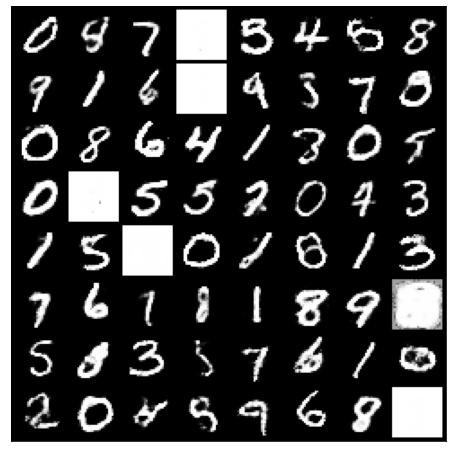

In [ ]:
latent_size = 100
batch_size = 100
image = []
device = "cuda"
for i in range(64):
  latent = torch.randn(batch_size, latent_size, device=device)
  fake_image = generator(latent)
  fake_image = fake_image.view(fake_image.size(0), 1, 28, 28)
  #fake_image = fake_image.cpu().detach().numpy() 
  image.append(fake_image[0].cpu())
#image = torch.FloatTensor(image) 
print(fake_image.shape)
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(image, nrow=8).permute(1, 2, 0))

torch.Size([100, 1, 28, 28])


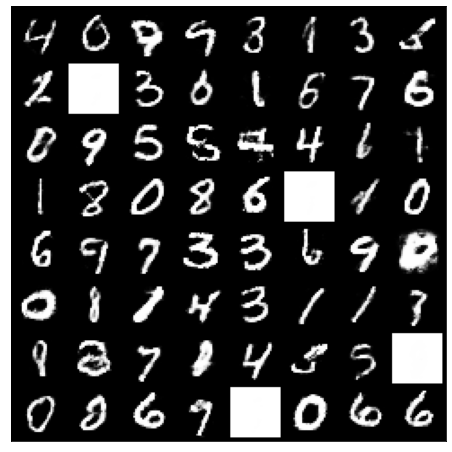

In [ ]:
latent_size = 100
batch_size = 100
image = []
device = "cuda"
for i in range(64):
  latent = torch.randn(batch_size, latent_size, device=device)
  fake_image = generator(latent)
  fake_image = fake_image.view(fake_image.size(0), 1, 28, 28)
  #fake_image = fake_image.cpu().detach().numpy() 
  image.append(fake_image[0].cpu())
#image = torch.FloatTensor(image) 
print(fake_image.shape)
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(image, nrow=8).permute(1, 2, 0))

torch.Size([100, 1, 28, 28])


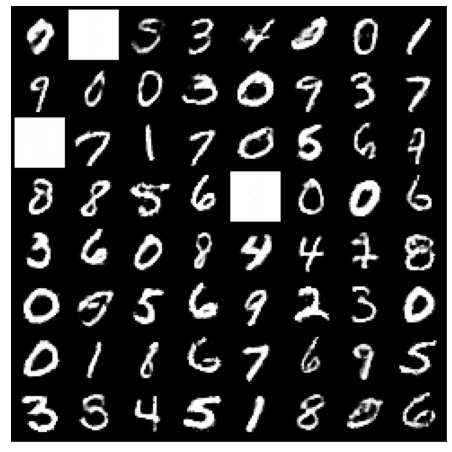

In [ ]:
latent_size = 100
batch_size = 100
image = []
device = "cuda"
for i in range(64):
  latent = torch.randn(batch_size, latent_size, device=device)
  fake_image = generator(latent)
  fake_image = fake_image.view(fake_image.size(0), 1, 28, 28)
  #fake_image = fake_image.cpu().detach().numpy() 
  image.append(fake_image[0].cpu())
#image = torch.FloatTensor(image) 
print(fake_image.shape)
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(image, nrow=8).permute(1, 2, 0))

torch.Size([100, 1, 28, 28])


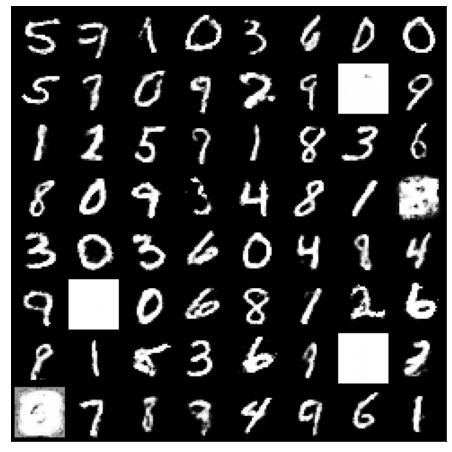

In [ ]:
latent_size = 100
batch_size = 100
image = []
device = "cuda"
for i in range(64):
  latent = torch.randn(batch_size, latent_size, device=device)
  fake_image = generator(latent)
  fake_image = fake_image.view(fake_image.size(0), 1, 28, 28)
  #fake_image = fake_image.cpu().detach().numpy() 
  image.append(fake_image[0].cpu())
#image = torch.FloatTensor(image) 
print(fake_image.shape)
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(image, nrow=8).permute(1, 2, 0))

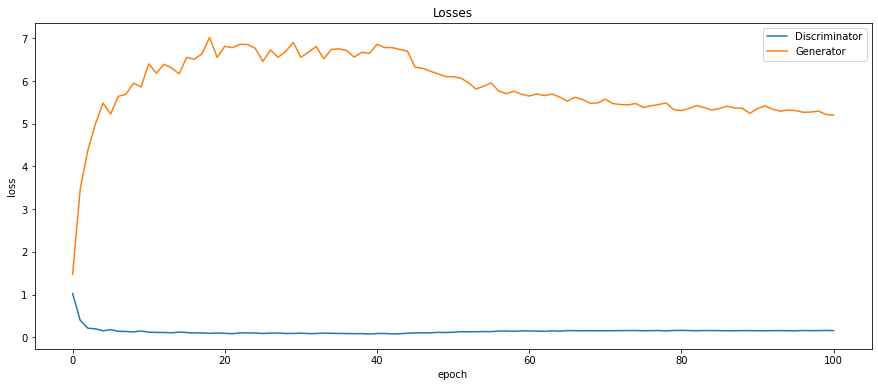

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');